In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
parkinsons = fetch_ucirepo(id=174) 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)


splits = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
n_estimators = 1024
kernels = ['linear', 'poly', 'rbf']
widths = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
regularization = [10**i for i in range(-7, 4)]
poly_degrees = [2, 3]

In [20]:
def kfold(X_train, y_train, rand_state):
    kf = KFold(n_splits=5, shuffle=True, random_state=rand_state)
    best_score = 0

    for kernel in kernels:
            if kernel == 'linear':
                for C in regularization:
                    scores = []
                    for train_idx, val_idx in kf.split(X_train):
                        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        svm = SVC(kernel=kernel, C=C, random_state=rand_state)
                        svm.fit(X_tr, y_tr)
                        scores.append(accuracy_score(y_val, svm.predict(X_val)))
                    avg_score = np.mean(scores)
                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {'kernel': 'linear', 'degree': None, 'gamma': None, 'C': C}
                        
            elif kernel == 'poly':
                for degree in poly_degrees:
                    for C in regularization:
                        scores = []
                        for train_idx, val_idx in kf.split(X_train):
                            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                            svm = SVC(kernel=kernel, degree=degree, C=C, random_state=rand_state)
                            svm.fit(X_tr, y_tr)
                            scores.append(accuracy_score(y_val, svm.predict(X_val)))
                        avg_score = np.mean(scores)
                        if avg_score > best_score:
                            best_score = avg_score
                            best_params = {'kernel': 'poly', 'degree': degree, 'gamma': None, 'C': C}

            elif kernel == 'rbf':
                for gamma in widths:
                    for C in regularization:
                        scores = []
                        for train_idx, val_idx in kf.split(X_train):
                            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                            svm = SVC(kernel=kernel, gamma=gamma, C=C, random_state=rand_state)
                            svm.fit(X_tr, y_tr)
                            scores.append(accuracy_score(y_val, svm.predict(X_val)))
                        avg_score = np.mean(scores)
                        if avg_score > best_score:
                            best_score = avg_score
                            best_params = {'kernel': 'rbf', 'degree': None, 'gamma': gamma, 'C': C}

    return best_score, best_params

In [23]:
def eval_split(X, y, train_size, test_size, rand_state):
    """Splits data, standardizes, trains SVM, and evaluates."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=rand_state)

    # Standardize features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Perform k-fold cross-validation
    best_cv_score, params = kfold(X_train, y_train, rand_state)
    print(f"CV Accuracy: {best_cv_score:.4f}")
    print(f"Best Parameters: {params}")

    best_kern = params["kernel"]

    if best_kern == 'linear':
        svm = SVC(kernel=best_kern, C=params['C'], random_state=rand_state)
    elif best_kern == 'poly':
        svm = SVC(kernel=best_kern, C=params['C'], random_state=rand_state,degree=params['degree'])
    else:
            svm = SVC(kernel=best_kern, C=params['C'], random_state=rand_state, gamma=params['gamma'])

    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    return test_accuracy, conf_matrix

In [ ]:
X= cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Parkinsons Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Diabetes Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
CV Accuracy: 0.8929
Best Parameters: {'kernel': 'poly', 'degree': 3, 'gamma': None, 'C': 100}
Test Accuracy: 0.8718
Trial 2:
CV Accuracy: 0.8964
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.005, 'C': 100}
Test Accuracy: 0.8590
Trial 3:
CV Accuracy: 0.9250
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.01, 'C': 1000}
Test Accuracy: 0.8590
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
CV Accuracy: 0.9068
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.05, 'C': 100}
Test Accuracy: 0.9082
Trial 2:
CV Accuracy: 0.9084
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.1, 'C': 100}
Test Accuracy: 0.8673
Trial 3:
CV Accuracy: 0.8863
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.05, 'C': 100}
Test Accuracy: 0.9286
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
CV Accuracy: 0.9296
Best Para

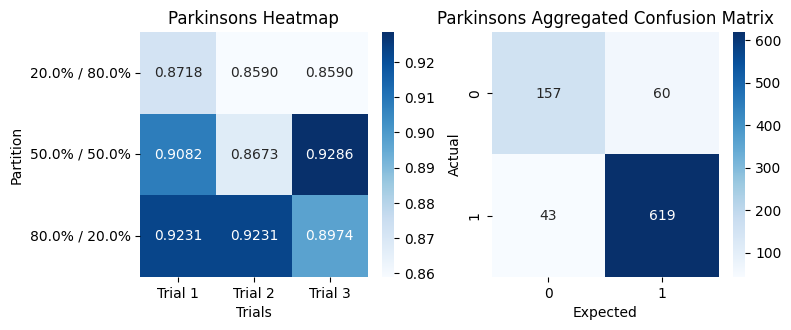

In [24]:
X= parkinsons.data.features
y = parkinsons.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Parkinsons Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Parkinsons Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
X= rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Rice Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Rice Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
CV Accuracy: 0.9239
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.001, 'C': 100}
Test Accuracy: 0.9295
Trial 2:
CV Accuracy: 0.9344
Best Parameters: {'kernel': 'linear', 'degree': None, 'gamma': None, 'C': 100}
Test Accuracy: 0.9291
Trial 3:
CV Accuracy: 0.9423
Best Parameters: {'kernel': 'linear', 'degree': None, 'gamma': None, 'C': 1000}
Test Accuracy: 0.9268
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
CV Accuracy: 0.9286
Best Parameters: {'kernel': 'linear', 'degree': None, 'gamma': None, 'C': 10}
Test Accuracy: 0.9360
Trial 2:
CV Accuracy: 0.9276
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.005, 'C': 1}
Test Accuracy: 0.9307
Trial 3:
CV Accuracy: 0.9228
Best Parameters: {'kernel': 'rbf', 'degree': None, 'gamma': 0.005, 'C': 1}
Test Accuracy: 0.9354
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
